In [1]:
# Importando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import RandomUnderSampler



from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron

from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

## Uniendo las diferentes tablas

In [2]:
# Cargando el archivo de usuarios
# Cargar el archivo Linea1-Usuarios y se usa el metodo DROP para eliminar las columnas innecesarias ['IND_ALTA','FEC_ALTA','USU_TELF','IP_Country','IP_Area','TIPOEMAIL']
usuarios = pd.read_csv('Linea1-Usuarios.txt', sep=';', encoding='latin-1').drop(['IND_ALTA','FEC_ALTA','USU_TELF','IP_Country','IP_Area','TIPOEMAIL'], axis=1)
# Transformar valores de FEC_CLIENTE y FEC_REGISTRO a tipo datatime[64]
usuarios['FEC_CLIENTE'] = pd.to_datetime(usuarios['FEC_CLIENTE'])
usuarios['FEC_REGISTRO'] = pd.to_datetime(usuarios['FEC_REGISTRO'])
usuarios.replace({pd.NaT: None}, inplace=True)
# Reemplazar los valores nulos de FEC_CLIENTE que están con IND_CLIENTE 1, con los valores en FEC_REGISTRO para las mismas filas
usuarios.loc[(usuarios['IND_CLIENTE'] == 1) & (pd.isnull(usuarios['FEC_CLIENTE'])),['FEC_CLIENTE']] = usuarios.loc[(usuarios['IND_CLIENTE'] == 1) & (pd.isnull(usuarios['FEC_CLIENTE'])),['FEC_REGISTRO']].values
# Mostrar los primeros 5 registros de la tabla usuarios
usuarios.head()

,IDUSUARIO,TIPOUSUARIO,FEC_REGISTRO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE
0,"8107310,00",PF,2019-10-22 00:00:00,3.0,0,0,1,None,None,None,None,None,None
1,"7784565,00",PJ,2019-05-14 00:00:00,3.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,N7820,ACTIVA,QUINDIO,None
2,"7718778,00",PJ,2019-09-04 00:00:00,7.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,G4774,ACTIVA,ATLANTICO,None
3,"7952765,00",PX,2019-12-08 00:00:00,3.0,0,20,1,None,None,None,None,None,None
4,"7855424,00",PJ,2019-06-21 00:00:00,7.0,0,20,1,EMPRESARIO INDIVIDUAL,MC,N8299,CANCELACIÓN,ATLANTICO,None


In [3]:
# Mostrar  cantidad de registros por indicativo de clientes antes del filtro de fechas
print(usuarios['IND_CLIENTE'].value_counts())

# Filtrar registros donde la fecha de cliente sea despues de la fecha de registro
usuarios_cliente_desp_reg = usuarios[usuarios['FEC_CLIENTE'] > usuarios['FEC_REGISTRO']]
# Filtrar registros con indicativo de cliente 0
usuarios_0 = usuarios[usuarios['IND_CLIENTE'] == 0]

# Unir dataframes
usuarios = pd.concat([usuarios_cliente_desp_reg, usuarios_0], ignore_index=True, axis=0)
# Mostrar  cantidad de registros por indicativo de clientes despues del filtro de fechas
print(usuarios['IND_CLIENTE'].value_counts())

0    365086
1      2619
Name: IND_CLIENTE, dtype: int64
0    365086
1      1057
Name: IND_CLIENTE, dtype: int64


In [4]:
# Descripcion del tipo de dato por columna para el dataframe usuarios
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366143 entries, 0 to 366142
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   IDUSUARIO         366143 non-null  object 
 1   TIPOUSUARIO       366143 non-null  object 
 2   FEC_REGISTRO      366143 non-null  object 
 3   CANAL_REGISTRO    358623 non-null  float64
 4   IND_CLIENTE       366143 non-null  int64  
 5   BONDAD_EMAIL      366143 non-null  int64  
 6   IPCASOS           366143 non-null  int64  
 7   USU_TIPO          83367 non-null   object 
 8   USU_TAMANIO       83369 non-null   object 
 9   USU_CIIU          83369 non-null   object 
 10  USU_ESTADO        83369 non-null   object 
 11  USU_DEPARTAMENTO  89733 non-null   object 
 12  FEC_CLIENTE       1057 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 36.3+ MB


In [5]:
# Cargando el archivo de consumos promocionales
# Cargar el archivo Linea1-Consumos Promocionales y se usa el metodo DROP para eliminar las columnas innecesarias (['IDCONSUMO', 'IDGRUPOPROD', 'IDPRODUCTO', 'EMPCONSUL_ID','EMPCONSUL_CIIU','EMPCONSUL_PROV','EMPCONSUL_EST', 'DESCGRUPOPROD']

consumo = pd.read_csv('Linea1-Consumos Promocionales.txt', sep=";", encoding='latin-1').drop(['IDCONSUMO', 'IDGRUPOPROD', 'IDPRODUCTO', 'EMPCONSUL_ID','EMPCONSUL_CIIU','EMPCONSUL_PROV','EMPCONSUL_EST', 'DESCGRUPOPROD'], axis=1)
# Convertir los valores de la variable FECHACONSUMO a su version en datatime[64]
consumo['FECHACONSUMO'] = pd.to_datetime(consumo['FECHACONSUMO'])
# Mostrar los primeros 5 registros de la tabla consumo
consumo.head()

,IDUSUARIO,DESCPRODUCTO,FECHACONSUMO
0,"6868835,00",Perfil Promocional,2018-01-01
1,"6868838,00",Perfil Promocional,2018-01-01
2,"6868841,00",Perfil Promocional,2018-01-01
3,"6868844,00",Perfil Promocional,2018-01-01
4,"6868841,00",Ficha Básica,2018-01-01


In [6]:
# Descripcion del tipo de variables por columna para el dataframe consumo
consumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796737 entries, 0 to 796736
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   IDUSUARIO     796737 non-null  object        
 1   DESCPRODUCTO  796737 non-null  object        
 2   FECHACONSUMO  796737 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 18.2+ MB


In [7]:
# Operacion de merge entre el df usuarios y consumo bajo el metodo de left join en el ID IDUSUARIO
usuarios_consumo = pd.merge(usuarios, consumo, on=['IDUSUARIO'], how='left')
# Organizar las columnas del resultado de merge por la variable de IDUSUARIO
usuarios_consumo = usuarios_consumo.sort_values('IDUSUARIO')


In [8]:
usuarios_consumo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789549 entries, 69623 to 234886
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   IDUSUARIO         789549 non-null  object        
 1   TIPOUSUARIO       789549 non-null  object        
 2   FEC_REGISTRO      789549 non-null  object        
 3   CANAL_REGISTRO    764110 non-null  float64       
 4   IND_CLIENTE       789549 non-null  int64         
 5   BONDAD_EMAIL      789549 non-null  int64         
 6   IPCASOS           789549 non-null  int64         
 7   USU_TIPO          152540 non-null  object        
 8   USU_TAMANIO       152544 non-null  object        
 9   USU_CIIU          152544 non-null  object        
 10  USU_ESTADO        152544 non-null  object        
 11  USU_DEPARTAMENTO  164515 non-null  object        
 12  FEC_CLIENTE       6376 non-null    object        
 13  DESCPRODUCTO      789544 non-null  object        
 14  

In [9]:
# Filtrar tabla de usuarios y consumo por filas en las que la fehc ade consumo sea antes o igual a la fecha de clientes
usuarios_consumo_c_1 = usuarios_consumo.loc[usuarios_consumo['FECHACONSUMO'] <= usuarios_consumo['FEC_CLIENTE']]

# Mensaje para mostrar los primeros 5 registros de la tabla usuarios_consumo con el filtro de fechas aplicados
print('IND_CLIENTE == 1', '\n')
print(usuarios_consumo_c_1.head())

# Filtrar usuarios en los que el indicativo de cliente sea igual a 0
usuarios_consumo_c_0 = usuarios_consumo.loc[(usuarios_consumo['IND_CLIENTE'] == 0)
                                            , :]

# Mensaje para mostrar los primeros 5 registros de la tabla usuarios_consumo con el filtro de indicativo de cliente aplicado (Iguales a 0)
print('\n\n')
print('IND_CLIENTE == 0', '\n')
print(usuarios_consumo_c_0.head())


IND_CLIENTE == 1 

       IDUSUARIO TIPOUSUARIO         FEC_REGISTRO  CANAL_REGISTRO  \
4827  6869752,00          PJ  2018-02-01 00:00:00             3.0   
4825  6869752,00          PJ  2018-02-01 00:00:00             3.0   
4826  6869752,00          PJ  2018-02-01 00:00:00             3.0   
4828  6869752,00          PJ  2018-02-01 00:00:00             3.0   
1890  6869802,00          PJ  2018-02-01 00:00:00             1.0   

      IND_CLIENTE  BONDAD_EMAIL  IPCASOS                       USU_TIPO  \
4827            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
4825            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
4826            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
4828            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
1890            1            20        3  SOCIEDAD COMERCIAL/INDUSTRIAL   

     USU_TAMANIO USU_CIIU USU_ESTADO USU_DEPARTAMENTO          FEC_CLIENTE  \
4827          GR    G4771     ACTIVA 

In [10]:
# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 1) nueva columna llamada  'DESC_FICHABASICA' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Ficha basica' y 0 en el caso contrario
usuarios_consumo_c_1.insert(len(usuarios_consumo_c_1.columns),
                            'DESC_FICHABASICA', 
                            (usuarios_consumo_c_1.loc[:,['DESCPRODUCTO']] == 'Ficha Básica').astype(int))
                            
# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 1) nueva columna llamada  'DESC_PERFILPROMOCIONAL' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Perfil Promocional' y 0 en el caso contrario
usuarios_consumo_c_1.insert(len(usuarios_consumo_c_1.columns),
                            'DESC_PERFILPROMOCIONAL',
                            (usuarios_consumo_c_1.loc[:,['DESCPRODUCTO']] == 'Perfil Promocional').astype(int))

# Eliminar columna de DESCPRODUCTO de la tabla de usuarios con indicativo 1
usuarios_consumo_c_1 = usuarios_consumo_c_1.drop(['DESCPRODUCTO'], axis=1)


# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 0) nueva columna llamada  'DESC_FICHABASICA' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Ficha basica' y 0 en el caso contrario
usuarios_consumo_c_0.insert(len(usuarios_consumo_c_0.columns),
                            'DESC_FICHABASICA', 
                            (usuarios_consumo_c_0.loc[:,['DESCPRODUCTO']] == 'Ficha Básica').astype(int))
                            

# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 0) nueva columna llamada  'DESC_PERFILPROMOCIONAL' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Perfil Promocional' y 0 en el caso contrario
usuarios_consumo_c_0.insert(len(usuarios_consumo_c_0.columns),
                            'DESC_PERFILPROMOCIONAL',
                            (usuarios_consumo_c_0.loc[:,['DESCPRODUCTO']] == 'Perfil Promocional').astype(int))

# Eliminar columna de DESCPRODUCTO de la tabla de usuarios con indicativo 0
usuarios_consumo_c_0 = usuarios_consumo_c_0.drop(['DESCPRODUCTO'], axis=1)

In [11]:
# Elección de que valores van a quedar por columna al aplicar la tabla dinamica (Groupby)
# 'first' indica que para al columna se mantendrá el primer valor encontrado
# 'sum' indica que para esa columna se sumaran los valores en la tabla dinamica
# 'count' indica que para esa columna se contarán los valores en la tabla dinamica
dicc = {
    'TIPOUSUARIO': 'first',
    'CANAL_REGISTRO': 'first',
    'IND_CLIENTE': 'first',
    'BONDAD_EMAIL': 'first',
    'IPCASOS': 'first',
    'USU_TIPO': 'first',
    'USU_TAMANIO': 'first',
    'USU_CIIU': 'first',
    'USU_ESTADO': 'first',
    'USU_DEPARTAMENTO': 'first',
    'FEC_CLIENTE': 'first',
    'DESC_FICHABASICA':'sum',
    'DESC_PERFILPROMOCIONAL':'sum',
    'FECHACONSUMO': 'count',
}

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 1) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_c_1 = usuarios_consumo_c_1.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FEHCACONSUMO por CONSUMOSTOTAL
usuarios_consumo_c_1 = usuarios_consumo_c_1.rename(columns={'FECHACONSUMO': 'CONSUMOSTOTAL'})

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 0) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_c_0 = usuarios_consumo_c_0.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FEHCACONSUMO por CONSUMOSTOTAL
usuarios_consumo_c_0 = usuarios_consumo_c_0.rename(columns={'FECHACONSUMO': 'CONSUMOSTOTAL'})

In [12]:
# Cargando el archivo de Linea1-Logins
logins = pd.read_csv('Linea1-Logins.txt', sep=';', encoding='latin-1')
# Reemplazar los valores de FECHALOGIN por su version en datatime[64]
logins['FECHALOGIN'] = pd.to_datetime(logins['FECHALOGIN'])
# Mostrar los primeros 5 registros de la tabla logins
logins.head()

,IDUSUARIO,FECHALOGIN
0,"7339406,00",2018-08-31
1,"7339406,00",2018-04-09
2,"7339406,00",2018-04-09
3,"7966293,00",2019-10-10
4,"7694472,00",2019-03-28


In [13]:
# Descripcion del tipo de datos por columna para la tabla logins
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617749 entries, 0 to 617748
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   IDUSUARIO   617749 non-null  object        
 1   FECHALOGIN  617749 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 9.4+ MB


In [14]:
# Operación de merge entre la tabla de usuarios_consumo (Con indicaivo 1) y logins sobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_c_1 = pd.merge(usuarios_consumo_c_1, logins, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1.sort_values('IDUSUARIO')

# Operación de merge entre la tabla de usuarios_consumo (Con indicaivo 0) y logins ensobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_c_0 = pd.merge(usuarios_consumo_c_0, logins, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_c_0 = usuarios_consumo_logins_c_0.sort_values('IDUSUARIO')

In [15]:
# Filtrando usuarios en los que la fecha de login sea antes o igual a la fecha de cliente
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1[usuarios_consumo_logins_c_1['FECHALOGIN'] <= usuarios_consumo_logins_c_1['FEC_CLIENTE']]


In [16]:
# Elección de que valores van a quedar por columna al aplicar la tabla dinamica (Groupby)
# 'first' indica que para al columna se mantendrá el primer valor encontrado
# 'count' indica que para esa columna se contarán los valores en la tabla dinamica
dicc = {
    'TIPOUSUARIO': 'first',
    'CANAL_REGISTRO': 'first',
    'IND_CLIENTE': 'first',
    'BONDAD_EMAIL': 'first',
    'IPCASOS': 'first',
    'USU_TIPO': 'first',
    'USU_TAMANIO': 'first',
    'USU_CIIU': 'first',
    'USU_ESTADO': 'first',
    'USU_DEPARTAMENTO': 'first',
    'FEC_CLIENTE': 'first',
    'DESC_FICHABASICA':'first',
    'DESC_PERFILPROMOCIONAL':'first',
    'CONSUMOSTOTAL':'first',
    'FECHALOGIN': 'count'
}

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 1) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FECHALOGIN por CANTIDADLOGIN
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1.rename(columns={'FECHALOGIN': 'CANTIDADLOGIN'})


# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 0) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_c_0 = usuarios_consumo_logins_c_0.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FEHCACONSUMO por CONSUMOSTOTAL
usuarios_consumo_logins_c_0 = usuarios_consumo_logins_c_0.rename(columns={'FECHALOGIN': 'CANTIDADLOGIN'})

In [17]:
# Cargando el archivo de Linea1-Sesiones
se = pd.read_csv('Linea1-Sesiones.txt', sep=';', encoding='latin-1')
# Reemplazar los valores de FECHA_SESION por su version en datatime[64]
se['FECHA_SESION'] = pd.to_datetime(se['FECHA_SESION'])
# Mostrar los primeros 5 registros de la tabla se
se.head()

,IDUSUARIO,FECHA_SESION,SESIONES
0,"6868835,00",2018-01-01,3
1,"6868838,00",2018-01-01,3
2,"6868841,00",2018-01-01,12
3,"6868844,00",2018-01-01,4
4,"6868847,00",2018-01-01,3


In [18]:
# Descripcion del tipo de datos por columna para la tabla se
se.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408028 entries, 0 to 408027
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   IDUSUARIO     408028 non-null  object        
 1   FECHA_SESION  408028 non-null  datetime64[ns]
 2   SESIONES      408028 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 9.3+ MB


In [19]:
# Operación de merge entre la tabla de usuarios_consumo_logins (Con indicaivo 1) y se sobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_se_c_1 = pd.merge(usuarios_consumo_logins_c_1, se, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.sort_values('IDUSUARIO')

# Operación de merge entre la tabla de usuarios_consumo_logins (Con indicaivo 0) y se sobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_se_c_0 = pd.merge(usuarios_consumo_logins_c_0, se, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.sort_values('IDUSUARIO')

In [20]:
# Filtrando usuarios en los que la fecha de sesion sea antes o igual a la fecha de cliente
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1[usuarios_consumo_logins_se_c_1['FECHA_SESION'] <= usuarios_consumo_logins_se_c_1['FEC_CLIENTE']]

In [21]:
# Elección de que valores van a quedar por columna al aplicar la tabla dinamica (Groupby)
# 'first' indica que para al columna se mantendrá el primer valor encontrado
# 'pd.Series.mean' indica que para esa columna se calculará el promedio de los valores
dicc = {
    'TIPOUSUARIO': 'first',
    'CANAL_REGISTRO': 'first',
    'IND_CLIENTE': 'first',
    'BONDAD_EMAIL': 'first',
    'IPCASOS': 'first',
    'USU_TIPO': 'first',
    'USU_TAMANIO': 'first',
    'USU_CIIU': 'first',
    'USU_ESTADO': 'first',
    'USU_DEPARTAMENTO': 'first',
    'FEC_CLIENTE': 'first',
    'DESC_FICHABASICA':'first',
    'DESC_PERFILPROMOCIONAL':'first',
    'CONSUMOSTOTAL':'first',
    'CANTIDADLOGIN': 'first',
    'FECHA_SESION': 'first',
    'SESIONES': pd.Series.mean
}

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 1) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna SESIONES por PROMEDIO_SESIONES
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.rename(columns={'SESIONES': 'PROMEDIO_SESIONES'})
# Eliminar columna de FECHA_SESION
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.drop(['FECHA_SESION'], axis=1)


# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 0) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna SESIONES por PROMEDIO_SESIONES
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.rename(columns={'SESIONES': 'PROMEDIO_SESIONES'})
# Eliminar columna de FECHA_SESION
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.drop(['FECHA_SESION'], axis=1)



In [22]:
# Mostrar tabla de usuarios con indicativo 0 y valores de consumo,login y sesiones
usuarios_consumo_logins_se_c_0

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6868835,00",PF,2.0,0,20,0,None,None,None,None,None,None,0,1,1,0,3.0
1,"6868838,00",PF,3.0,0,20,0,None,None,None,None,None,None,0,1,1,2,3.0
2,"6868841,00",PJ,3.0,0,0,0,EMPRESARIO INDIVIDUAL,MC,Q8610,CANCELACIÓN,ATLANTICO,None,4,3,7,1,12.0
3,"6868844,00",PJ,6.0,0,20,0,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,E3600,ACTIVA,BOGOTA,None,0,1,1,1,4.0
4,"6868847,00",PJ,2.0,0,1,0,EMPRESARIO INDIVIDUAL,MC,G4520,ACTIVA,CESAR,None,0,1,1,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365081,"8250344,00",PF,9.0,0,20,1,None,None,None,None,None,None,0,1,1,0,3.0
365082,"8250350,00",PJ,2.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,R9312,ACTIVA,BOGOTA,None,0,1,1,0,3.0
365083,"8250356,00",PF,2.0,0,0,1,None,None,None,None,None,None,0,1,1,0,3.0
365084,"8250359,00",PF,8.0,0,20,1,None,None,None,None,None,None,0,1,1,0,3.0


In [23]:
# Mostrar tabla de usuarios con indicativo 1 y valores de consumo,login y sesiones
usuarios_consumo_logins_se_c_1

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,GR,G4771,ACTIVA,BOGOTA,2020-09-30,4,0,4,17,13.500000
1,"6869802,00",PJ,1.0,1,20,3,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,J6202,ACTIVA,BOGOTA,2018-03-01,2,0,2,8,3.000000
2,"6870488,00",PF,1.0,1,20,8,None,None,None,None,None,2018-09-04,8,1,9,15,5.250000
3,"6870818,00",PF,2.0,1,20,1,None,None,None,None,None,2019-12-07,2,1,3,8,5.500000
4,"6871584,00",PJ,6.0,1,20,1,ENTIDAD SIN ANIMO DE LUCRO,MC,M7220,ACTIVA,BOGOTA,2019-02-05,1,1,2,9,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,"8237821,00",PF,7.0,1,20,0,None,None,None,None,None,2020-01-29,7,1,8,14,6.333333
1031,"8242616,00",PJ,9.0,1,20,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6629,ACTIVA,ANTIOQUIA,2020-01-20,2,3,5,10,7.000000
1032,"8245916,00",PF,2.0,1,20,2,None,None,None,None,None,2020-09-18,0,1,1,10,5.000000
1033,"8248811,00",PJ,4.0,1,20,7,EMPRESARIO INDIVIDUAL,MC,N8299,ACTIVA,ATLANTICO,2020-01-15,2,0,2,13,6.500000


In [24]:
# Crear dataframe final con los usuarios de indicativo 0 y 1 con todos los calculos por consumo, logins, y sesiones
usuarios_final = pd.concat([usuarios_consumo_logins_se_c_1, usuarios_consumo_logins_se_c_0], ignore_index=True, axis=0)
# Eliminar columna de FEC_CLIENTE
df=usuarios_final.drop(['FEC_CLIENTE'], axis=1)

In [25]:
# Mostrar dataframe final
df

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,GR,G4771,ACTIVA,BOGOTA,4,0,4,17,13.50
1,"6869802,00",PJ,1.0,1,20,3,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,J6202,ACTIVA,BOGOTA,2,0,2,8,3.00
2,"6870488,00",PF,1.0,1,20,8,None,None,None,None,None,8,1,9,15,5.25
3,"6870818,00",PF,2.0,1,20,1,None,None,None,None,None,2,1,3,8,5.50
4,"6871584,00",PJ,6.0,1,20,1,ENTIDAD SIN ANIMO DE LUCRO,MC,M7220,ACTIVA,BOGOTA,1,1,2,9,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366116,"8250344,00",PF,9.0,0,20,1,None,None,None,None,None,0,1,1,0,3.00
366117,"8250350,00",PJ,2.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,R9312,ACTIVA,BOGOTA,0,1,1,0,3.00
366118,"8250356,00",PF,2.0,0,0,1,None,None,None,None,None,0,1,1,0,3.00
366119,"8250359,00",PF,8.0,0,20,1,None,None,None,None,None,0,1,1,0,3.00


In [26]:
# Valores par indicativo cliente
df['IND_CLIENTE'].value_counts()

0    365086
1      1035
Name: IND_CLIENTE, dtype: int64

## Análisis descriptivo del dataframe

In [27]:
# Mostrar numero de columnas y filas del dataframe final()
rows, cols = df.shape
print('No. de Filas:', rows)
print('No. de Columnas:', cols)

No. de Filas: 366121
No. de Columnas: 16


In [28]:
# Mostrando el porcentaje de las filas con valores nulos por cada columna
a = df.isnull().sum()/len(df)*100

print('Los porcentajes de valores faltantes son: \n', a)


Los porcentajes de valores faltantes son: 
 IDUSUARIO                  0.000000
TIPOUSUARIO                0.000000
CANAL_REGISTRO             2.053966
IND_CLIENTE                0.000000
BONDAD_EMAIL               0.000000
IPCASOS                    0.000000
USU_TIPO                  77.232664
USU_TAMANIO               77.232117
USU_CIIU                  77.232117
USU_ESTADO                77.232117
USU_DEPARTAMENTO          75.493894
DESC_FICHABASICA           0.000000
DESC_PERFILPROMOCIONAL     0.000000
CONSUMOSTOTAL              0.000000
CANTIDADLOGIN              0.000000
PROMEDIO_SESIONES          0.000000
dtype: float64


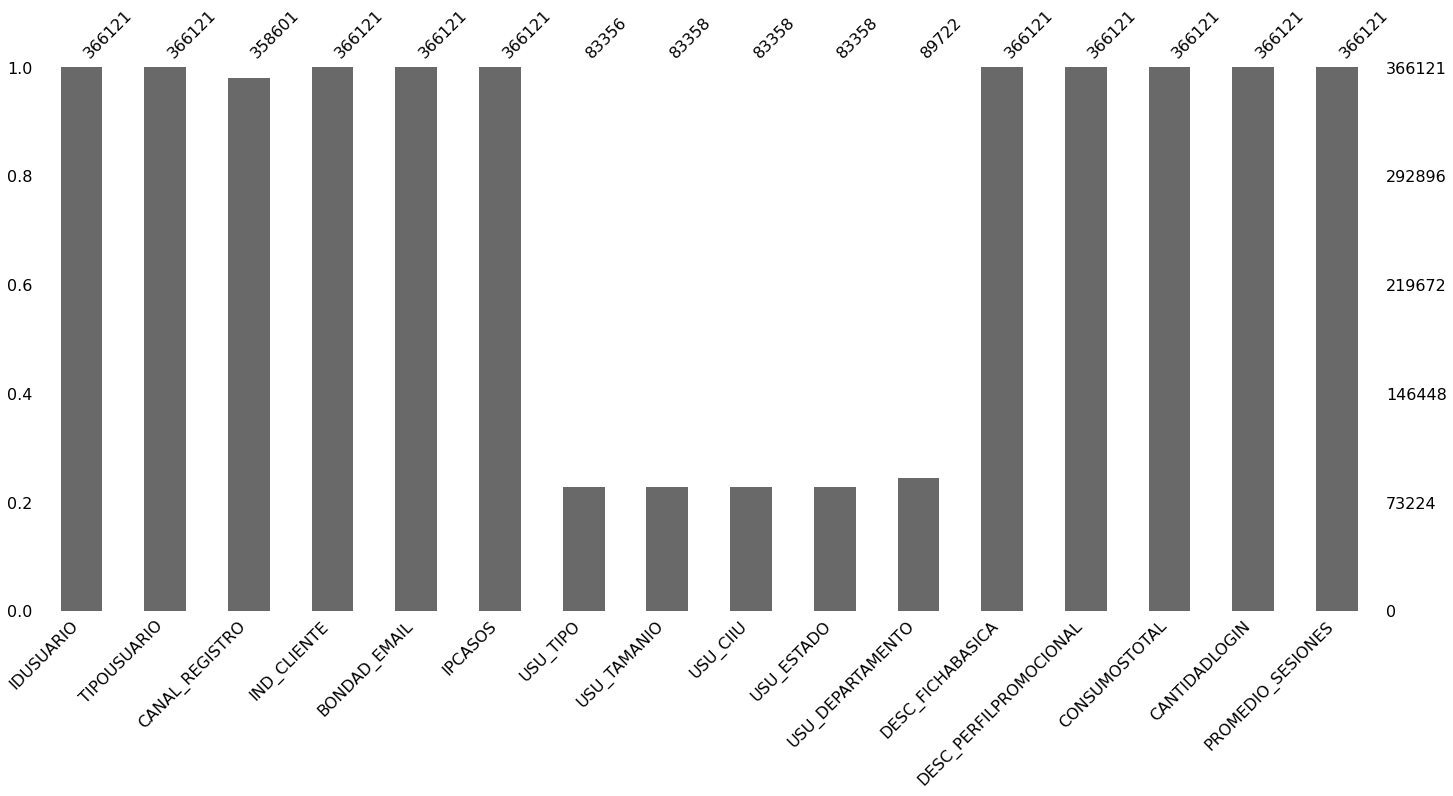

In [29]:
# Graficando la info de los valores faltantes
msno.bar(df);

In [30]:
# Se eliminan las columnas que tienen el 70% o más de valores faltantes
limitPer = len(df) * .70
sub_df = df.dropna(thresh=limitPer, axis=1)

In [31]:
# Mostrar los primeros 5 registros de la tabla resultante del filtro de valores faltantes
sub_df.head()

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,4,0,4,17,13.50
1,"6869802,00",PJ,1.0,1,20,3,2,0,2,8,3.00
2,"6870488,00",PF,1.0,1,20,8,8,1,9,15,5.25
3,"6870818,00",PF,2.0,1,20,1,2,1,3,8,5.50
4,"6871584,00",PJ,6.0,1,20,1,1,1,2,9,3.00


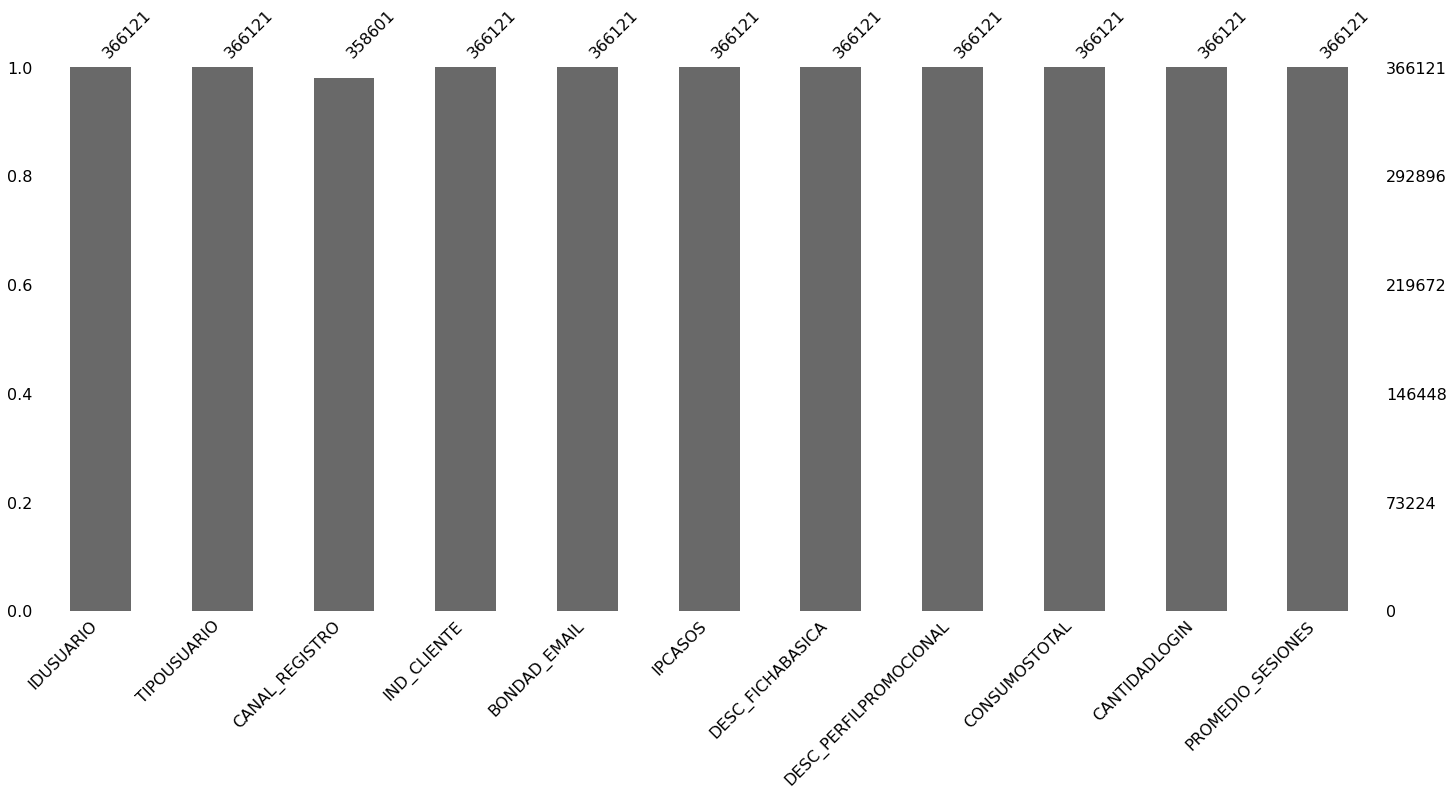

In [32]:
# Graficando la info de los valores faltantes otra vez
msno.bar(sub_df);

In [33]:
# Eliminar filas con valores nulos
sub_df = sub_df.dropna()
# Mostrar numero de filas y columnas resultantes del filtro
sub_df.shape

(358601, 11)

In [34]:
# Mostrar tabla resultante del filtro
sub_df

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,4,0,4,17,13.50
1,"6869802,00",PJ,1.0,1,20,3,2,0,2,8,3.00
2,"6870488,00",PF,1.0,1,20,8,8,1,9,15,5.25
3,"6870818,00",PF,2.0,1,20,1,2,1,3,8,5.50
4,"6871584,00",PJ,6.0,1,20,1,1,1,2,9,3.00
...,...,...,...,...,...,...,...,...,...,...,...
366116,"8250344,00",PF,9.0,0,20,1,0,1,1,0,3.00
366117,"8250350,00",PJ,2.0,0,20,1,0,1,1,0,3.00
366118,"8250356,00",PF,2.0,0,0,1,0,1,1,0,3.00
366119,"8250359,00",PF,8.0,0,20,1,0,1,1,0,3.00


In [35]:
# Resumen estadistico por cada columna numerica
sub_df.describe()

,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
count,358601.000000,358601.000000,358601.000000,358601.000000,358601.000000,358601.000000,358601.000000,358601.000000,358601.000000
mean,3.897245,0.002867,14.127855,356.322157,0.988673,1.141433,2.130106,1.680416,4.694903
std,2.412264,0.053465,10.977585,1710.183749,9.190479,0.850263,9.350455,4.879850,5.575046
min,1.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,0.000000,20.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000
50%,3.000000,0.000000,20.000000,2.000000,0.000000,1.000000,1.000000,1.000000,3.000000
75%,7.000000,0.000000,20.000000,5.000000,1.000000,1.000000,2.000000,2.000000,4.000000
max,9.000000,1.000000,20.000000,16393.000000,3206.000000,5.000000,3207.000000,1307.000000,552.000000


### Tratatamiento de Valores Extremos

count    358601.000000
mean        356.322157
std        1710.183749
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       16393.000000
Name: IPCASOS, dtype: float64
count    348937.000000
mean        108.729711
std         531.308656
min           0.000000
25%           1.000000
50%           1.000000
75%           5.000000
max        4260.000000
Name: IPCASOS, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1a93e0c4550>,
 'caps': [<matplotlib.lines.Line2D at 0x1a93e0c4c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a93e0c41c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a93e0ce3d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a93e0ce760>],
 'means': []}

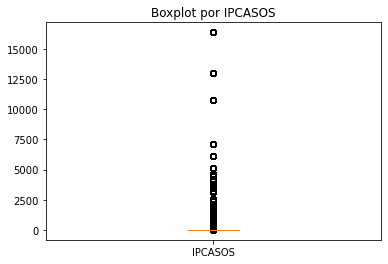

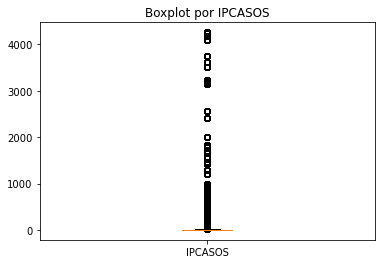

In [36]:
# Descripción de la data
# IPCASOS
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por IPCASOS')
# Box plot por IPCASOS
ax.boxplot(sub_df['IPCASOS'], labels=["IPCASOS"])

# Mostrar descripcion estadistica de la columna IPCASOS
print(sub_df['IPCASOS'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna IPCASOS) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.IPCASOS - sub_df.IPCASOS.mean()) < (5*sub_df.IPCASOS.std())]
# Eliminacion de registros que su valor absoluto (Para la columna IPCASOS) tiene +5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.IPCASOS - sub_df.IPCASOS.mean()) > (5*sub_df.IPCASOS.std()))]
# Mostrar descripcion estadistica de la columna IPCASOS
print(sub_df['IPCASOS'].describe())
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por IPCASOS')
ax.boxplot(sub_df['IPCASOS'], labels=["IPCASOS"])

count    348937.000000
mean          0.857949
std           9.210818
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        3206.000000
Name: DESC_FICHABASICA, dtype: float64
count    346601.000000
mean          0.669311
std           1.451501
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          10.000000
Name: DESC_FICHABASICA, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1a93f729580>,
 'caps': [<matplotlib.lines.Line2D at 0x1a93f729ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a93f7291f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a93f736400>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a93f736790>],
 'means': []}

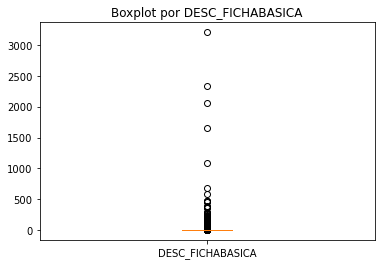

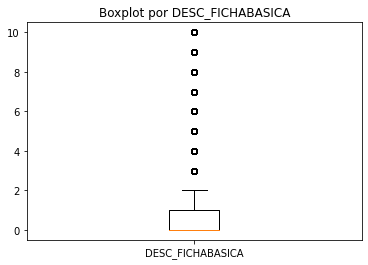

In [37]:
##DESC_FICHABASICA
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por DESC_FICHABASICA')
# Box plot por DESC_FICHABASICA
ax.boxplot(sub_df['DESC_FICHABASICA'], labels=["DESC_FICHABASICA"])
# Mostrar descripcion estadistica de la columna DESC_FICHABASICA
print(sub_df['DESC_FICHABASICA'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna DESC_FICHABASICA) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.DESC_FICHABASICA - sub_df.DESC_FICHABASICA.mean()) < (5*sub_df.DESC_FICHABASICA.std())]
# Eliminacion de registros que su valor absoluto (Para la columna DESC_FICHABASICA) tiene +5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.DESC_FICHABASICA - sub_df.DESC_FICHABASICA.mean()) > (5*sub_df.DESC_FICHABASICA.std()))]
# Mostrar descripcion estadistica de la columna DESC_FICHABASICA
print(sub_df['DESC_FICHABASICA'].describe())
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por DESC_FICHABASICA')
# Box plot por DESC_FICHABASICA
ax.boxplot(sub_df['DESC_FICHABASICA'], labels=["DESC_FICHABASICA"])

count    346601.00000
mean          1.07867
std           0.72181
min           0.00000
25%           1.00000
50%           1.00000
75%           1.00000
max           5.00000
Name: DESC_PERFILPROMOCIONAL, dtype: float64


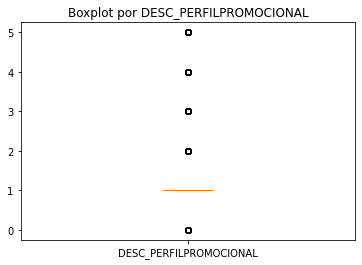

In [38]:
##DESC_PERFILPROMOCIONAL
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por DESC_PERFILPROMOCIONAL')
# Box plot por DESC_PERFILPROMOCIONAL
ax.boxplot(sub_df['DESC_PERFILPROMOCIONAL'], labels=["DESC_PERFILPROMOCIONAL"])
# Mostrar descripcion estadistica de la columna DESC_PERFILPROMOCIONAL
print(sub_df['DESC_PERFILPROMOCIONAL'].describe())

count    346601.000000
mean          1.747981
std           1.937527
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
Name: CONSUMOSTOTAL, dtype: float64


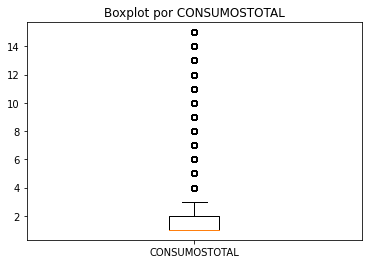

In [39]:
##CONSUMOSTOTAL
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por CONSUMOSTOTAL')
# Box plot por CONSUMOSTOTAL
ax.boxplot(sub_df['CONSUMOSTOTAL'], labels=["CONSUMOSTOTAL"])
# Mostrar descripcion estadistica de la columna CONSUMOSTOTAL
print(sub_df['CONSUMOSTOTAL'].describe())

count    346601.000000
mean          1.549485
std           3.922251
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         481.000000
Name: CANTIDADLOGIN, dtype: float64
count    343769.000000
mean          1.355308
std           2.074116
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: CANTIDADLOGIN, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1a93fc23670>,
 'caps': [<matplotlib.lines.Line2D at 0x1a93fc23d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a93fc232e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a93fc324f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a93fc32880>],
 'means': []}

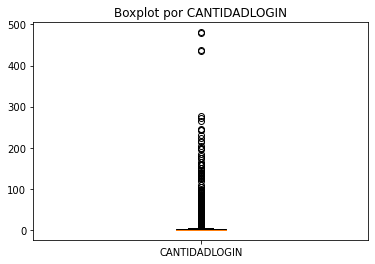

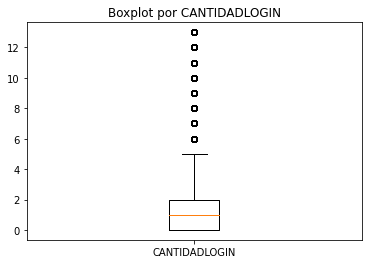

In [40]:
##CANTIDADLOGIN
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por CANTIDADLOGIN')
# Box plot por CANTIDADLOGIN
ax.boxplot(sub_df['CANTIDADLOGIN'], labels=["CANTIDADLOGIN"])
# Mostrar descripcion estadistica de la columna CANTIDADLOGIN
print(sub_df['CANTIDADLOGIN'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna CANTIDADLOGIN) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.CANTIDADLOGIN - sub_df.CANTIDADLOGIN.mean()) < (5*sub_df.CANTIDADLOGIN.std())]
# Eliminacion de registros que su valor absoluto (Para la columna CANTIDADLOGIN) tiene -5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.CANTIDADLOGIN - sub_df.CANTIDADLOGIN.mean()) > (5*sub_df.CANTIDADLOGIN.std()))]
# Mostrar descripcion estadistica de la columna CANTIDADLOGIN
print(sub_df['CANTIDADLOGIN'].describe())

# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por CANTIDADLOGIN')
# Box plot por CANTIDADLOGIN
ax.boxplot(sub_df['CANTIDADLOGIN'], labels=["CANTIDADLOGIN"])

count    343769.000000
mean          4.191194
std           3.188078
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          50.000000
Name: PROMEDIO_SESIONES, dtype: float64
count    335795.000000
mean          3.798509
std           1.831483
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          15.500000
Name: PROMEDIO_SESIONES, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1a93fc8ccd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a93fc9c430>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a93fc8c940>],
 'medians': [<matplotlib.lines.Line2D at 0x1a93fc9cb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a93fc9cee0>],
 'means': []}

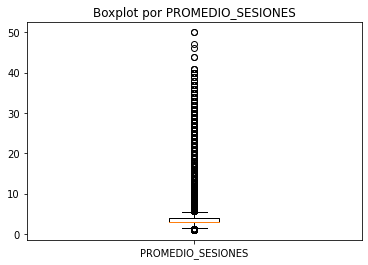

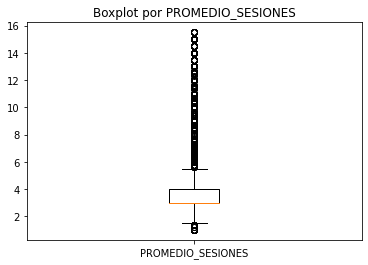

In [41]:
##PROMEDIO_SESIONES
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por PROMEDIO_SESIONES')
# Box plot por PROMEDIO_SESIONES
ax.boxplot(sub_df['PROMEDIO_SESIONES'], labels=["PROMEDIO_SESIONES"])
# Mostrar descripcion estadistica de la columna PROMEDIO_SESIONES
print(sub_df['PROMEDIO_SESIONES'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna PROMEDIO_SESIONES) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.PROMEDIO_SESIONES - sub_df.PROMEDIO_SESIONES.mean()) < (5*sub_df.PROMEDIO_SESIONES.std())]
# Eliminacion de registros que su valor absoluto (Para la columna PROMEDIO_SESIONES) tiene +5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.PROMEDIO_SESIONES - sub_df.PROMEDIO_SESIONES.mean()) > (5*sub_df.PROMEDIO_SESIONES.std()))]
# Mostrar descripcion estadistica de la columna PROMEDIO_SESIONES
print(sub_df['PROMEDIO_SESIONES'].describe())

# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por PROMEDIO_SESIONES')
# Box plot por PROMEDIO_SESIONES
ax.boxplot(sub_df['PROMEDIO_SESIONES'], labels=["PROMEDIO_SESIONES"])

In [42]:
# Resumen estadistico para el dataframe resultante
sub_df.describe()

,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
count,335795.000000,335795.000000,335795.000000,335795.000000,335795.000000,335795.000000,335795.000000,335795.000000,335795.000000
mean,3.999994,0.002329,14.770443,81.771813,0.529746,0.996682,1.526428,1.299397,3.798509
std,2.404966,0.048202,10.613341,443.472809,1.156561,0.470922,1.350688,2.017916,1.831483
min,1.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,0.000000,20.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000
50%,3.000000,0.000000,20.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.000000
75%,7.000000,0.000000,20.000000,4.000000,1.000000,1.000000,1.000000,2.000000,4.000000
max,9.000000,1.000000,20.000000,4260.000000,10.000000,5.000000,15.000000,13.000000,15.500000


In [43]:
# Mostrar primeros registros del dataframe
sub_df



,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
1,"6869802,00",PJ,1.0,1,20,3,2,0,2,8,3.0
3,"6870818,00",PF,2.0,1,20,1,2,1,3,8,5.5
4,"6871584,00",PJ,6.0,1,20,1,1,1,2,9,3.0
5,"6872102,00",PJ,1.0,1,20,5,3,1,4,3,4.0
7,"6873020,00",PJ,4.0,1,20,4,2,1,3,3,3.5
...,...,...,...,...,...,...,...,...,...,...,...
366116,"8250344,00",PF,9.0,0,20,1,0,1,1,0,3.0
366117,"8250350,00",PJ,2.0,0,20,1,0,1,1,0,3.0
366118,"8250356,00",PF,2.0,0,0,1,0,1,1,0,3.0
366119,"8250359,00",PF,8.0,0,20,1,0,1,1,0,3.0


In [44]:
# Reemplazar valores de PF, PJ, y PX por valores numericos representativos
sub_df.loc[sub_df['TIPOUSUARIO'] == 'PF',  ['TIPOUSUARIO']] = 1
sub_df.loc[sub_df['TIPOUSUARIO'] == 'PJ',  ['TIPOUSUARIO']] = 2
sub_df.loc[sub_df['TIPOUSUARIO'] == 'PX',  ['TIPOUSUARIO']] = 3

# Crear dataframe X sin columnas de IDUSUARIO e IND_CLIENTE
X = sub_df.drop(['IDUSUARIO', 'IND_CLIENTE'], axis=1)
# Crear dataframe Y solo con los valores de IND_CLIENTE
y = sub_df['IND_CLIENTE']


In [45]:
# Convertir columna CANAL_REGISTRO a tipo category
sub_df['CANAL_REGISTRO'] = sub_df['CANAL_REGISTRO'].astype('category')
# Convertir columna TIPOUSUARIO a tipo category
sub_df['TIPOUSUARIO'] = sub_df['TIPOUSUARIO'].astype('category')
# Convertir columna BONDAD_EMAIL a tipo category
sub_df['BONDAD_EMAIL'] = sub_df['BONDAD_EMAIL'].astype('category')


### Estudio de Colinealidad

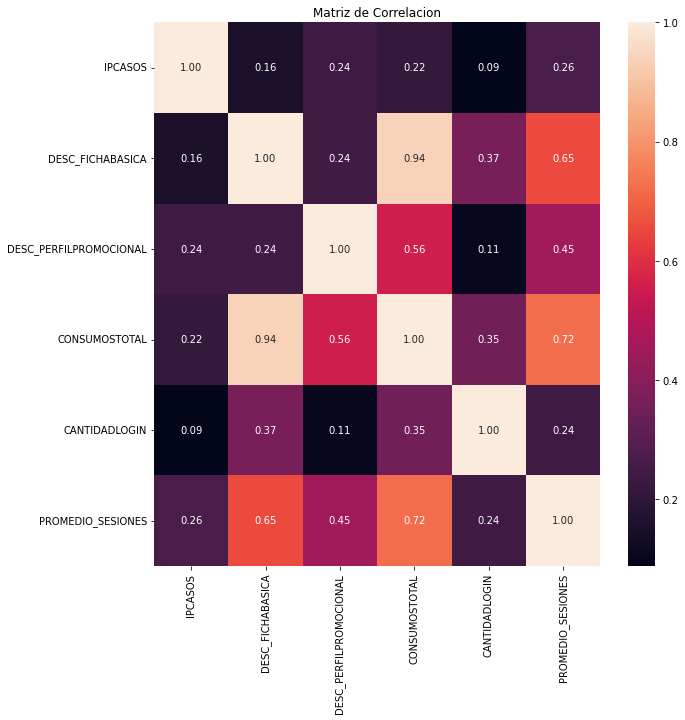

In [46]:
# Crear canvas para crear figura
plt.figure(figsize=(10, 10))
# Crear matriz de correlación entre las columnas ['IDUSUARIO', 'IND_CLIENTE', 'BONDAD_EMAIL', 'CANAL_REGISTRO', 'TIPOUSUARIO']
sns.heatmap(sub_df.drop(['IDUSUARIO', 'IND_CLIENTE', 'BONDAD_EMAIL', 'CANAL_REGISTRO', 'TIPOUSUARIO'], axis=1).corr(), annot=True, fmt='.2f')
# Agregar titulo a la grafica
plt.title('Matriz de Correlacion')
# Mostrar resultadod e la grafica
plt.show()

In [47]:
# Existe correlación entre las variables de CONSUMOTOTAL y DESC_FICHABASICA pues la primera es el resultado de una suma con la segunda
# Debido a esta dependencia se decirió no eliminar ninguna de estas 2 variables.
# Respecto a las otras no se encontró colinealidad

In [48]:
# Restablecer indices del dataframe
sub_df.reset_index(inplace=True, drop=True)

In [49]:
sub_df

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869802,00",2,1.0,1,20,3,2,0,2,8,3.0
1,"6870818,00",1,2.0,1,20,1,2,1,3,8,5.5
2,"6871584,00",2,6.0,1,20,1,1,1,2,9,3.0
3,"6872102,00",2,1.0,1,20,5,3,1,4,3,4.0
4,"6873020,00",2,4.0,1,20,4,2,1,3,3,3.5
...,...,...,...,...,...,...,...,...,...,...,...
335790,"8250344,00",1,9.0,0,20,1,0,1,1,0,3.0
335791,"8250350,00",2,2.0,0,20,1,0,1,1,0,3.0
335792,"8250356,00",1,2.0,0,0,1,0,1,1,0,3.0
335793,"8250359,00",1,8.0,0,20,1,0,1,1,0,3.0


### PCA

In [50]:
##Crear data con variables continuas para pca
sub_df_continuas = sub_df[['IPCASOS','DESC_FICHABASICA','DESC_PERFILPROMOCIONAL','CONSUMOSTOTAL','CANTIDADLOGIN','PROMEDIO_SESIONES']]
##Crear data con variables categoricas
sub_df_categoricas = sub_df[['IDUSUARIO','TIPOUSUARIO','CANAL_REGISTRO','IND_CLIENTE','BONDAD_EMAIL']]

In [51]:
# Estandarizar valores de las columnas continuas
X_scaled = StandardScaler().fit_transform(sub_df_continuas)
# Bajo pruebas anteriores se decidió crear 4 componentes principales que mejor representan los datos
# Crear instancia de PCA para realizar el calculo
pca = PCA(n_components=4)
# Realizar PCA a los valores estandarizados
pca_principal = pca.fit_transform(X_scaled)
# Crear dataframe con los valores de cada componente
pca_df = pd.DataFrame(data = pca_principal,
                      columns = ['PC1','PC2','PC3','PC4'])


In [52]:
# Mostrar valores de los componentes
pca_df

,PC1,PC2,PC3,PC4
0,0.719461,-3.227422,2.534684,0.237855
1,2.502536,-2.209838,1.584555,-0.971623
2,1.148696,-2.245999,2.302369,-1.835845
3,2.301771,-1.325307,-0.077000,0.523760
4,1.337230,-1.026253,0.158293,0.083073
...,...,...,...,...
335790,-0.850966,0.349325,-0.369116,-0.015936
335791,-0.850966,0.349325,-0.369116,-0.015936
335792,-0.850966,0.349325,-0.369116,-0.015936
335793,-0.850966,0.349325,-0.369116,-0.015936


In [53]:
# Varianza explicada con los 4 componentes
pca.explained_variance_ratio_.sum()

0.9398033474705271

In [54]:
# Suma acumulada de la varianza explicada por componente
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

array([51.4, 68.6, 82.7, 94. ])

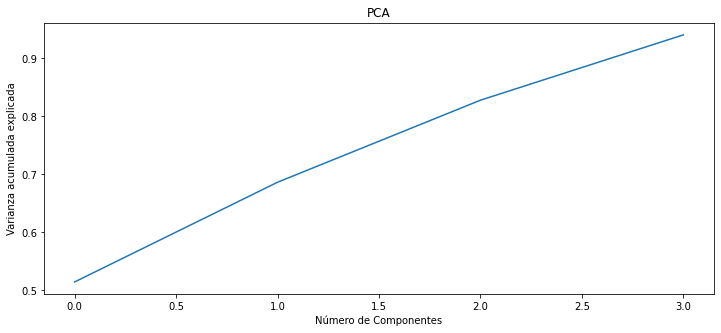

In [55]:

# Crear canvas para colocar figura
plt.figure(figsize=(12, 5))
# Plotear la suma acumulada de la varianza explicada por el PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
# Colocar titulo
plt.title('PCA')
# Colocar nombre del eje X
plt.xlabel('Número de Componentes')
# Colocar nombre del eje Y
plt.ylabel('Varianza acumulada explicada');

In [56]:
# Descripcion de cada componente según las variables continuas
pca_df2 = pd.DataFrame(data = pca.components_,
                       columns = sub_df_continuas.columns,
                       index = ['PC1','PC2','PC3','PC4'])

# Mstrar tabla de componentes
pca_df2
                    

,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
PC1,0.204316,0.497426,0.344131,0.545917,0.261296,0.475495
PC2,0.652116,-0.294261,0.462717,-0.090641,-0.509812,0.076962
PC3,0.666472,-0.080808,-0.290940,-0.170631,0.642971,-0.148705
PC4,0.276938,0.385090,-0.703240,0.084556,-0.496737,0.162998


Text(0, 0.5, 'Por. varianza explicada')

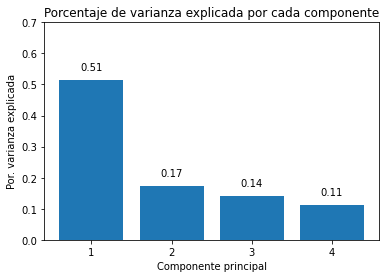

In [57]:
# Crear canvas para colocar figura
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
# Plotear en barras valor de cada componente
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

# Crear labels para el Eje X y Y (Valores 1, 2, 3, 4 con el valor de cada varianza)
for x, y in zip(np.arange(len(sub_df_continuas.columns)) + 1, pca.explained_variance_ratio_):
    # Crear label de los ejes por componente
    label = round(y, 2)
    # Agregar a la grafica valores por eje
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

# Crear valores para el eje X
ax.set_xticks(np.arange(pca.n_components_) + 1)
# Crear valores para el eje y
ax.set_ylim(0,0.7)
# Crear titulo
ax.set_title('Porcentaje de varianza explicada por cada componente')
# Nombre del eje x
ax.set_xlabel('Componente principal')
# Nombre del eje y
ax.set_ylabel('Por. varianza explicada')

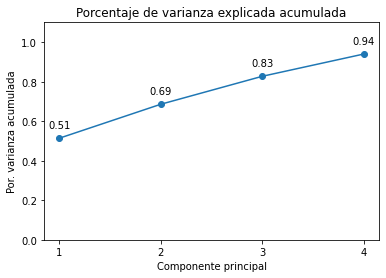

In [58]:
# Calcular varianza acumulada por componente
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
# Crear canvas para colocar figura
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
# Plotear en linea conitnua valor de cada componente
ax.plot(
    np.arange(pca.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)
# Crear labels para el Eje X y Y (Valores 1, 2, 3, 4 con el valor de cada varianza)
for x, y in zip(np.arange(len(sub_df_continuas.columns)) + 1, prop_varianza_acum):
    # Crear label de los ejes por componente
    label = round(y, 2)
    # Agregar a la grafica valores por eje
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
# Crear valores para el eje y
ax.set_ylim(0, 1.1)
# Crear valores para el eje X
ax.set_xticks(np.arange(pca.n_components_) + 1)
# Crear titulo
ax.set_title('Porcentaje de varianza explicada acumulada')
# Nombre del eje x
ax.set_xlabel('Componente principal')
# Nombre del eje y
ax.set_ylabel('Por. varianza acumulada');

In [59]:
##Uniendo DataFrames (Componentes y variables categoricas del dataframe inicial)
df_1 = pd.concat([pca_df,sub_df[['TIPOUSUARIO','CANAL_REGISTRO','IND_CLIENTE','BONDAD_EMAIL']]],axis=1)
# Mostrando resumen de la tabla final con PCA y demás variables
df_1

,PC1,PC2,PC3,PC4,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL
0,0.719461,-3.227422,2.534684,0.237855,2,1.0,1,20
1,2.502536,-2.209838,1.584555,-0.971623,1,2.0,1,20
2,1.148696,-2.245999,2.302369,-1.835845,2,6.0,1,20
3,2.301771,-1.325307,-0.077000,0.523760,2,1.0,1,20
4,1.337230,-1.026253,0.158293,0.083073,2,4.0,1,20
...,...,...,...,...,...,...,...,...
335790,-0.850966,0.349325,-0.369116,-0.015936,1,9.0,0,20
335791,-0.850966,0.349325,-0.369116,-0.015936,2,2.0,0,20
335792,-0.850966,0.349325,-0.369116,-0.015936,1,2.0,0,0
335793,-0.850966,0.349325,-0.369116,-0.015936,1,8.0,0,20


### Pruebas de Chi-cuadrado para variables categóricas

In [60]:
##Prueba chicuadrado para variables categóricas

##Tipo usuario vs Canal Registro

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para TIPOUSUARIO Y CANAL_REGISTRO)
tabla_dobleEntrada = pd.crosstab(df_1['TIPOUSUARIO'],df_1['CANAL_REGISTRO'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)
# Valor de confianza
alpha = 0.05
# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: No existe Dependencia')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

CANAL_REGISTRO    1.0    2.0     3.0    4.0    6.0    7.0    8.0   9.0     All
TIPOUSUARIO                                                                   
1               18633  62788   79984   9336   8138  22600  33827  4516  239822
2                3429  19467   31086   1665   3460  12084  11852  1820   84863
3                 841   1107    5725    346    276   1465   1115   235   11110
All             22903  83362  116795  11347  11874  36149  46794  6571  335795
CANAL_REGISTRO       1.0       2.0       3.0       4.0       6.0       7.0  \
TIPOUSUARIO                                                                  
1               0.077695  0.261811  0.333514  0.038929  0.033934  0.094237   
2               0.040406  0.229393  0.366308  0.019620  0.040772  0.142394   
3               0.075698  0.099640  0.515302  0.031143  0.024842  0.131863   
All             0.068205  0.248253  0.347816  0.033791  0.035361  0.107652   

CANAL_REGISTRO       8.0       9.0  All  
TIPOUSUARIO    

In [61]:
##Prueba chicuadrado para variables categóricas

##Tipo usuario vs Bondad Email

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para TIPOUSUARIO Y BONDAD_EMAIL)
tabla_dobleEntrada = pd.crosstab(df_1['TIPOUSUARIO'],df_1['BONDAD_EMAIL'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: No existe Dependencia')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

BONDAD_EMAIL    -20    -10      0     1     9      20     All
TIPOUSUARIO                                                  
1              8078   9474  33171  3306  2278  183515  239822
2              2579   2113   6654  1257  1450   70810   84863
3               287    446   1361   202   186    8628   11110
All           10944  12033  41186  4765  3914  262953  335795
BONDAD_EMAIL       -20       -10         0         1         9        20  All
TIPOUSUARIO                                                                  
1             0.033683  0.039504  0.138315  0.013785  0.009499  0.765213  1.0
2             0.030390  0.024899  0.078409  0.014812  0.017086  0.834404  1.0
3             0.025833  0.040144  0.122502  0.018182  0.016742  0.776598  1.0
All           0.032591  0.035834  0.122652  0.014190  0.011656  0.783076  1.0
P valor es 0.0
Se rechaza Ho: No existe Dependencia


In [62]:
##Prueba chicuadrado para variables categóricas
##Canal_Registro vs Bondad Email

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para CANAL_REGISTRO Y BONDAD_EMAIL)
tabla_dobleEntrada = pd.crosstab(df_1['CANAL_REGISTRO'],df_1['BONDAD_EMAIL'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: No existe Dependencia')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

BONDAD_EMAIL      -20    -10      0     1     9      20     All
CANAL_REGISTRO                                                 
1.0               552   2451   7425   179   557   11739   22903
2.0              4030   2455   6839  1243  1107   67688   83362
3.0              3780   3485  13476  1808  1112   93134  116795
4.0               306    978   3498    88   147    6330   11347
6.0               257    329   1068   150   122    9948   11874
7.0              1019    867   3307   576   387   29993   36149
8.0               989   1305   4918   641   425   38516   46794
9.0                11    163    655    80    57    5605    6571
All             10944  12033  41186  4765  3914  262953  335795
BONDAD_EMAIL         -20       -10         0         1         9        20  \
CANAL_REGISTRO                                                               
1.0             0.024102  0.107017  0.324193  0.007816  0.024320  0.512553   
2.0             0.048343  0.029450  0.082040  0.014911  0.0132

In [63]:
##Prueba chicuadrado para variables categóricas

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para IND_CLIENTE Y BONDAD_EMAIL)
tabla_dobleEntrada = pd.crosstab(df_1['IND_CLIENTE'],df_1['BONDAD_EMAIL'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: No existe Dependencia')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

BONDAD_EMAIL    -20    -10      0     1     9      20     All
IND_CLIENTE                                                  
0             10939  12030  41171  4757  3909  262207  335013
1                 5      3     15     8     5     746     782
All           10944  12033  41186  4765  3914  262953  335795
BONDAD_EMAIL       -20       -10         0         1         9        20  All
IND_CLIENTE                                                                  
0             0.032652  0.035909  0.122894  0.014199  0.011668  0.782677  1.0
1             0.006394  0.003836  0.019182  0.010230  0.006394  0.953964  1.0
All           0.032591  0.035834  0.122652  0.014190  0.011656  0.783076  1.0
P valor es 8.370512718923214e-24
Se rechaza Ho: No existe Dependencia


In [64]:
##Prueba chicuadrado para variables categóricas

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para IND_CLIENTE Y CANAL_REGISTRO)
tabla_dobleEntrada = pd.crosstab(df_1['IND_CLIENTE'],df_1['CANAL_REGISTRO'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: No existe Dependencia')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

CANAL_REGISTRO    1.0    2.0     3.0    4.0    6.0    7.0    8.0   9.0     All
IND_CLIENTE                                                                   
0               22796  83214  116608  11292  11828  35992  46724  6559  335013
1                 107    148     187     55     46    157     70    12     782
All             22903  83362  116795  11347  11874  36149  46794  6571  335795
CANAL_REGISTRO       1.0       2.0       3.0       4.0       6.0       7.0  \
IND_CLIENTE                                                                  
0               0.068045  0.248390  0.348070  0.033706  0.035306  0.107435   
1               0.136829  0.189258  0.239130  0.070332  0.058824  0.200767   
All             0.068205  0.248253  0.347816  0.033791  0.035361  0.107652   

CANAL_REGISTRO       8.0       9.0  All  
IND_CLIENTE                              
0               0.139469  0.019578  1.0  
1               0.089514  0.015345  1.0  
All             0.139353  0.019568  1.0  
P va

In [65]:
##Prueba chicuadrado para variables categóricas

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency

# Crear tabulación cruzada entre los factores (Tabla de contingencia para TIPOUSUARIO Y CANAL_REGISTRO)
tabla_dobleEntrada = pd.crosstab(df_1['IND_CLIENTE'],df_1['TIPOUSUARIO'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: No existe Dependencia')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

TIPOUSUARIO       1      2      3     All
IND_CLIENTE                              
0            239458  84479  11076  335013
1               364    384     34     782
All          239822  84863  11110  335795
TIPOUSUARIO         1         2         3  All
IND_CLIENTE                                   
0            0.714772  0.252166  0.033061  1.0
1            0.465473  0.491049  0.043478  1.0
All          0.714192  0.252723  0.033086  1.0
P valor es 2.1684325272293013e-50
Se rechaza Ho: No existe Dependencia


In [66]:
# De acuerdo a las pruebas de Chi_cuadrado no hay dependencia entre las variables por lo cual no se elimina ninguna

# Mostrar resumen del dataframe
df_1

,PC1,PC2,PC3,PC4,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL
0,0.719461,-3.227422,2.534684,0.237855,2,1.0,1,20
1,2.502536,-2.209838,1.584555,-0.971623,1,2.0,1,20
2,1.148696,-2.245999,2.302369,-1.835845,2,6.0,1,20
3,2.301771,-1.325307,-0.077000,0.523760,2,1.0,1,20
4,1.337230,-1.026253,0.158293,0.083073,2,4.0,1,20
...,...,...,...,...,...,...,...,...
335790,-0.850966,0.349325,-0.369116,-0.015936,1,9.0,0,20
335791,-0.850966,0.349325,-0.369116,-0.015936,2,2.0,0,20
335792,-0.850966,0.349325,-0.369116,-0.015936,1,2.0,0,0
335793,-0.850966,0.349325,-0.369116,-0.015936,1,8.0,0,20


#### Selección de características

In [67]:
sub_df = df_1
# Convertir columna CANAL_REGISTRO a tipo entero
sub_df['CANAL_REGISTRO'] = sub_df['CANAL_REGISTRO'].astype(int)
# Convertir columna TIPOUSUARIO a tipo entero
sub_df['TIPOUSUARIO'] = sub_df['TIPOUSUARIO'].astype(int)
# Convertir columna BONDAD_EMAIL a tipo entero
sub_df['BONDAD_EMAIL'] = sub_df['BONDAD_EMAIL'].astype(int)

In [68]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE y BONDAD_EMAIL
sub_df.groupby(['IND_CLIENTE', 'BONDAD_EMAIL'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE BONDAD_EMAIL             
0           -20                 10939
            -10                 12030
             0                  41171
             1                   4757
             9                   3909
             20                262207
1           -20                     5
            -10                     3
             0                     15
             1                      8
             9                      5
             20                   746

In [69]:
# Por 2 razones se deciden eliminar las subcategorias -20, -10, 0 y 1 de BONDAD_EMAIL
# La primera porque el correo de acuerdo a la Bondad del email no existe, es inválido de forma pemanente o envia la campaña a Spam
# Segundo, porque al eliminar esos registros se estan eliminando 21% de registros que no son clientes vs solo 4.8% que se elimnan que si lo son.

In [70]:
# Eliminar valores de BONDAD_EMAIL que sean -10, 0, -20 y 1
temp_df = sub_df[(sub_df['BONDAD_EMAIL'] != -10) & (sub_df['BONDAD_EMAIL'] != 0) & (sub_df['BONDAD_EMAIL'] != -20) & (sub_df['BONDAD_EMAIL'] != 1)]
# Reemplazar columna BONDAD_EMAIL por su version en tipo categoría
temp_df['BONDAD_EMAIL'] = temp_df['BONDAD_EMAIL'].astype('category')

# Reemplazar dataframe inicial por el filtro aplicado a BONDAD_EMAIL
sub_df = temp_df
# Crear vista de tabla dinamica (Contar) por IND_CLIENTE y BONDAD_EMAIL
sub_df.groupby(['IND_CLIENTE', 'BONDAD_EMAIL'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE BONDAD_EMAIL             
0           9                    3909
            20                 262207
1           9                       5
            20                    746

In [71]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE
sub_df.groupby(['IND_CLIENTE'])[['IND_CLIENTE']].count()

,IND_CLIENTE
IND_CLIENTE,
0,266116
1,751


In [72]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE y CANAL_REGISTRO
sub_df.groupby(['IND_CLIENTE', 'CANAL_REGISTRO'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE CANAL_REGISTRO             
0           1                     12198
            2                     68650
            3                     94067
            4                      6426
            6                     10026
            7                     30227
            8                     38872
            9                      5650
1           1                        98
            2                       145
            3                       179
            4                        51
            6                        44
            7                       153
            8                        69
            9                        12

In [73]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE y TIPOUSUARIO
sub_df.groupby(['IND_CLIENTE', 'TIPOUSUARIO'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE TIPOUSUARIO             
0           1                 185441
            2                  71893
            3                   8782
1           1                    352
            2                    367
            3                     32

In [74]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE
sub_df.groupby(['IND_CLIENTE'])[['IND_CLIENTE']].count()

,IND_CLIENTE
IND_CLIENTE,
0,266116
1,751


In [75]:
# Convertir columna CANAL_REGISTRO a tipo category
sub_df['CANAL_REGISTRO'] = sub_df['CANAL_REGISTRO'].astype('category')
# Convertir columna TIPOUSUARIO a tipo category
sub_df['TIPOUSUARIO'] = sub_df['TIPOUSUARIO'].astype('category')

In [76]:
df_final = sub_df
df_final

,PC1,PC2,PC3,PC4,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL
0,0.719461,-3.227422,2.534684,0.237855,2,1,1,20
1,2.502536,-2.209838,1.584555,-0.971623,1,2,1,20
2,1.148696,-2.245999,2.302369,-1.835845,2,6,1,20
3,2.301771,-1.325307,-0.077000,0.523760,2,1,1,20
4,1.337230,-1.026253,0.158293,0.083073,2,4,1,20
...,...,...,...,...,...,...,...,...
335789,-0.889894,-1.384145,0.825105,1.321772,2,4,0,20
335790,-0.850966,0.349325,-0.369116,-0.015936,1,9,0,20
335791,-0.850966,0.349325,-0.369116,-0.015936,2,2,0,20
335793,-0.850966,0.349325,-0.369116,-0.015936,1,8,0,20


In [77]:
# Crear nombre final para el dataset final
file_name = "clientesdiadespues.csv"
# Exportar a csv
df_final.to_csv(file_name, sep=';')

# Técnicas de Balanceo de Datos

In [78]:
# Crear dataframe X con el dataframe sin la columna de IND_CLIENTE
X = df_final.drop(['IND_CLIENTE'], axis=1)
# Algoritmo de OneHot Encoder para las columnas del dataframe X
X = pd.get_dummies(X)
# Crear dataframe Y con la columna de IND_CLIENTE
y = df_final['IND_CLIENTE']



In [79]:
# Se dividen los datos en entrenamiento (80%) y prueba (20%) datos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.2)

In [80]:
def construiryevaluar_modelo(model, model_name):
    # Activar variabkles globales que serán modificadas con cada modelo de balanceo
    global X_train_balanced, y_train_balanced
    '''Función para construir el modelo y evaluar el rendimiento'''
    # Entrenando el modelo
    model.fit(X_train_balanced, y_train_balanced)
    # Obteniendo puntuación de validación cruzada kfold
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5)
    # Se predicen los datos de prueba
    y_pred = model.predict(X_test)
    # Guardando el valor de exactitud
    exactitud = accuracy_score(y_test, y_pred)
    # Imprimiendo puntaje de la exactitud
    print("Exactitud: %0.3f" % exactitud)
    # Imprimiendo puntaje de la validación cruzada
    print("Validación Cruzada: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    # Impimiendo reporte de la precision, recall, f1 score, soporte
    print(classification_report(y_test, y_pred))
    # Imprimiendo la matriz de confusión
    plot_confusion_matrix(model ,X_test, y_test)
    # Agregar titulo al grafico
    plt.title('Matriz de Confusión ' + model_name)
    # Mostrar grafico
    plt.show()
    
    # Guardando el valor de precision
    precision = precision_score(y_test, y_pred, average='macro')
    # Guardando el valor de recall
    recall = recall_score(y_test, y_pred, average='macro')
    # Guardando f1 score
    f1 = 2*((precision * recall) / (precision + recall))
    # Guardando f2 score
    f2 = 5 * (precision * recall) / ((4 * precision) + recall)


    
    #  Retornando la Matriz de Evaluación
    return {'Nombre del Modelo': model_name,
           'Validación Cruzada': scores.mean(),
           'Exactitud': exactitud,
           'Precisión': precision,
           'Recall': recall,
           'F1-Score': f1,
           'F2-Score': f2
           }

In [81]:
# Crear dataframes (Sin balancear) como punto de comparación con los demas
X_train_balanced, y_train_balanced = (X_train, y_train)


In [82]:
# Calcular cantida de valores por indicativo de cliente
y_train_balanced.value_counts()

0    212919
1       574
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.997
Validación Cruzada: 0.997 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53197
           1       0.25      0.01      0.01       177

    accuracy                           1.00     53374
   macro avg       0.62      0.50      0.50     53374
weighted avg       0.99      1.00      1.00     53374



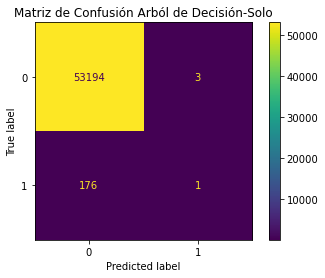

In [83]:
# Crear lista con el resultado de cada modelo del balanceo
results = []
# Evaluar modelo de Arboles de decision sin balanceo de datos
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-Solo'))

## Sobremuestreo Aleatorio

In [84]:
# Crear instancia del algoritmo de Sobremuestreo Aleatorio
randover = RandomOverSampler(sampling_strategy='auto', random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = randover.fit_resample(X_train, y_train)

In [85]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    212919
1    212919
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.894
Validación Cruzada: 0.934 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     53197
           1       0.02      0.72      0.04       177

    accuracy                           0.89     53374
   macro avg       0.51      0.81      0.49     53374
weighted avg       1.00      0.89      0.94     53374



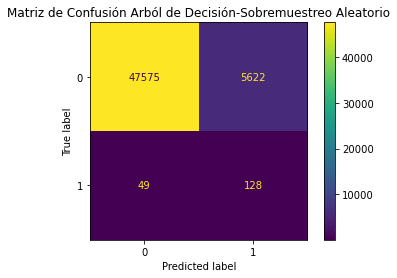

In [86]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo de Sobremuestreo Aleatorio
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-Sobremuestreo Aleatorio'))

## Submuestreo Aleatorio

In [87]:
# Crear instancia del algoritmo de submuestreo Aleatorio
randunder = RandomUnderSampler(sampling_strategy='auto', random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = randunder.fit_resample(X_train, y_train)

In [88]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    574
1    574
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.848
Validación Cruzada: 0.849 (+/- 0.04)
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     53197
           1       0.02      0.86      0.04       177

    accuracy                           0.85     53374
   macro avg       0.51      0.86      0.48     53374
weighted avg       1.00      0.85      0.91     53374



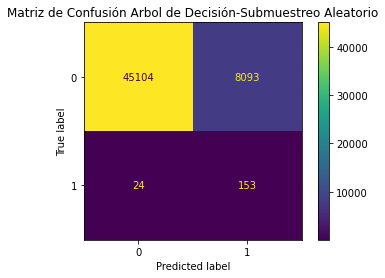

In [89]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo de Submuestreo Aleatorio
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arbol de Decisión-Submuestreo Aleatorio'))

## Smote-Técnica de Sobremuestreo

In [90]:
# Crear instancia del algoritmo SMOTE
smote = SMOTE(random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [91]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    212919
1    212919
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.888
Validación Cruzada: 0.939 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     53197
           1       0.02      0.84      0.05       177

    accuracy                           0.89     53374
   macro avg       0.51      0.86      0.49     53374
weighted avg       1.00      0.89      0.94     53374



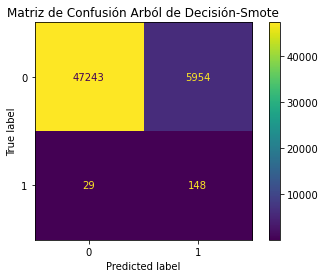

In [92]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo de SMOTE
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-Smote'))

## OneSidedSelection-Técnica de Submuestreo

In [93]:
# Crear instancia del algoritmo de OneSidedSelection
onesided = OneSidedSelection(random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = onesided.fit_resample(X_train, y_train)

In [94]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    155387
1       574
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.996
Validación Cruzada: 0.996 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53197
           1       0.19      0.03      0.05       177

    accuracy                           1.00     53374
   macro avg       0.59      0.51      0.52     53374
weighted avg       0.99      1.00      1.00     53374



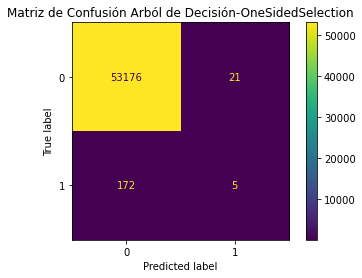

In [95]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo OneSidedSelection
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-OneSidedSelection'))

## Comparación

In [96]:
# Crear tabla con los resultados de cada modelo de balanceo
# Y ordenar de mayor a menor por el F2-Score
per_df = pd.json_normalize(results).set_index('Nombre del Modelo').sort_values(['F2-Score'],  ascending = False)
# Mostrar tabla de resultados
per_df


,Validación Cruzada,Exactitud,Precisión,Recall,F1-Score,F2-Score
Nombre del Modelo,,,,,,
Arból de Decisión-Smote,0.939099,0.887904,0.511820,0.862117,0.642313,0.758317
Arbol de Decisión-Submuestreo Aleatorio,0.849326,0.847922,0.509011,0.856137,0.638441,0.753382
Arból de Decisión-Sobremuestreo Aleatorio,0.933700,0.893750,0.510616,0.808741,0.625996,0.724178
Arból de Decisión-OneSidedSelection,0.995954,0.996384,0.594542,0.513927,0.551303,0.528252
Arból de Decisión-Solo,0.997096,0.996646,0.623351,0.502797,0.556621,0.523027


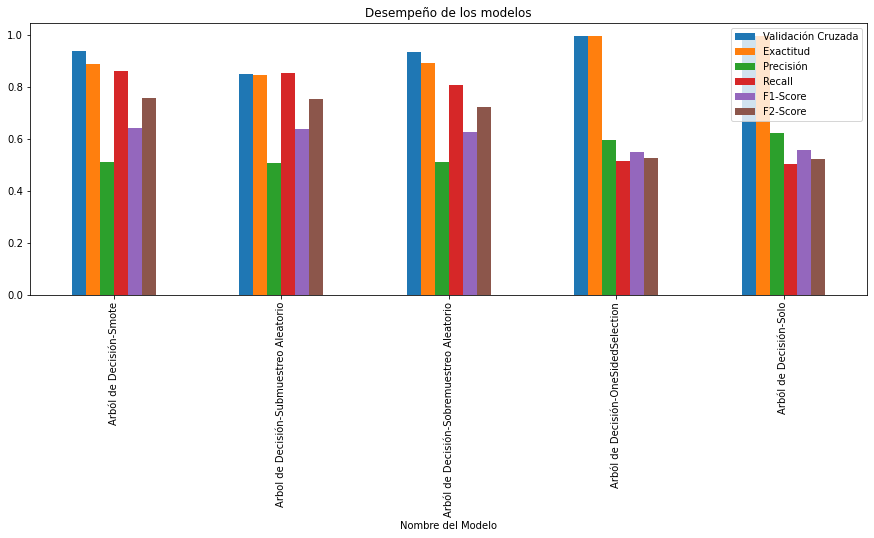

In [97]:
# Crear grafica de barras con los resultados de cada modelo de balanceo de datos
per_df.plot(kind='bar', figsize=(15, 5), title='Desempeño de los modelos');

In [98]:
# De acuerdo a los resultados obtenidos la dos mejores tecnicas fueron:
# Sobremuestreo de datos y submuestreo de datos
# Se decidió escoger para los siguientes modelos
# la técnica de sobremuestreo aleatorio
# Aunque el recall por muy poco es inferior a la de submuestreo aleatorio
# los demás parámetros(validacion cruzada, precision y excatitud son mejores en este)

# Generando otros modelos de clasificación con la mejor técnica de balanceo de datos

In [99]:
# Crear instancia del algoritmo SMOTE
smote = SMOTE(random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [100]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    212919
1    212919
Name: IND_CLIENTE, dtype: int64

## Análisis discriminante lineal

Exactitud: 0.925
Validación Cruzada: 0.870 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     53197
           1       0.03      0.74      0.06       177

    accuracy                           0.92     53374
   macro avg       0.52      0.83      0.51     53374
weighted avg       1.00      0.92      0.96     53374



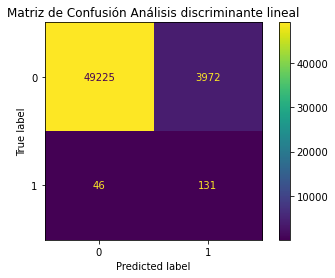

In [101]:
# Crear lista con los resultados de cada modelo
results = []
# Evaluar modelo de Análisis discriminante lineal con balanceo de datos
# bajo el metodo SMOTE
results.append(construiryevaluar_modelo(LinearDiscriminantAnalysis(), 'Análisis discriminante lineal'))

## Gradient Boosting

Exactitud: 0.892
Validación Cruzada: 0.926 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     53197
           1       0.03      0.83      0.05       177

    accuracy                           0.89     53374
   macro avg       0.51      0.86      0.50     53374
weighted avg       1.00      0.89      0.94     53374



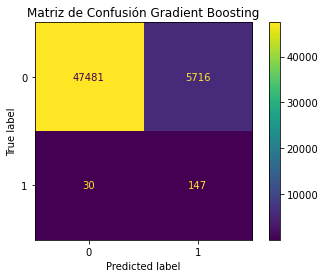

In [102]:
# Evaluar modelo de Gradient Boosting con balanceo de datos
# bajo el metodo SMOTE
results.append(construiryevaluar_modelo(GradientBoostingClassifier(random_state=0), 'Gradient Boosting'))

## GaussianNB

Exactitud: 0.325
Validación Cruzada: 0.638 (+/- 0.06)
              precision    recall  f1-score   support

           0       1.00      0.32      0.49     53197
           1       0.00      0.89      0.01       177

    accuracy                           0.33     53374
   macro avg       0.50      0.61      0.25     53374
weighted avg       1.00      0.33      0.49     53374



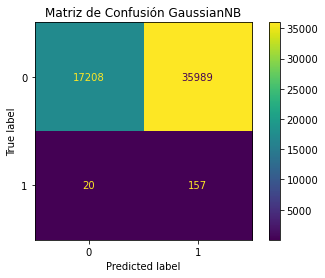

In [103]:
# Evaluar modelo de AdaBoosting con balanceo de datos
# bajo el metodo Sobremuestreo aleatorio
results.append(construiryevaluar_modelo(GaussianNB(), 'GaussianNB'))


## Arbol de decisión

Exactitud: 0.888
Validación Cruzada: 0.939 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     53197
           1       0.02      0.84      0.05       177

    accuracy                           0.89     53374
   macro avg       0.51      0.86      0.49     53374
weighted avg       1.00      0.89      0.94     53374



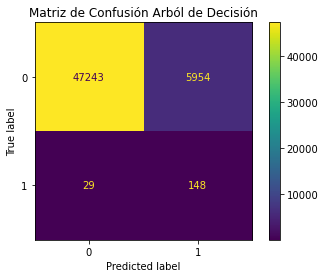

In [104]:
# Evaluar modelo de Arbol de decisión con balanceo de datos
# bajo el metodo SMOTE
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión'))

## Perceptron

Exactitud: 0.866
Validación Cruzada: 0.844 (+/- 0.07)
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     53197
           1       0.02      0.82      0.04       177

    accuracy                           0.87     53374
   macro avg       0.51      0.84      0.48     53374
weighted avg       1.00      0.87      0.93     53374



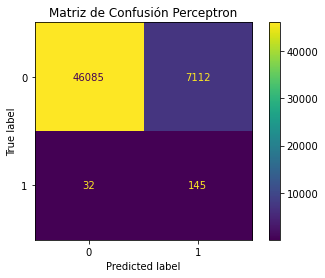

In [105]:
# Evaluar modelo de Arbol de decisión con balanceo de datos
# bajo el metodo SMOTE
results.append(construiryevaluar_modelo(Perceptron(random_state=0), 'Perceptron'))

## Comparación de modelos

In [106]:
# Crear tabla con el resumen de los resultados de los modelos
# Y ordenar de mayor a menor por el F2-Score
per_df = pd.json_normalize(results).set_index('Nombre del Modelo').sort_values(['F2-Score'],  ascending = False)
# Mostrar tabla con el resumen de resultados por modelo
per_df

,Validación Cruzada,Exactitud,Precisión,Recall,F1-Score,F2-Score
Nombre del Modelo,,,,,,
Arból de Decisión,0.939099,0.887904,0.511820,0.862117,0.642313,0.758317
Gradient Boosting,0.925883,0.892345,0.512221,0.861529,0.642465,0.758128
Perceptron,0.844037,0.866152,0.509643,0.842759,0.635176,0.745326
Análisis discriminante lineal,0.869922,0.924720,0.515497,0.832724,0.636790,0.741467
GaussianNB,0.638402,0.325346,0.501591,0.605241,0.548563,0.581220


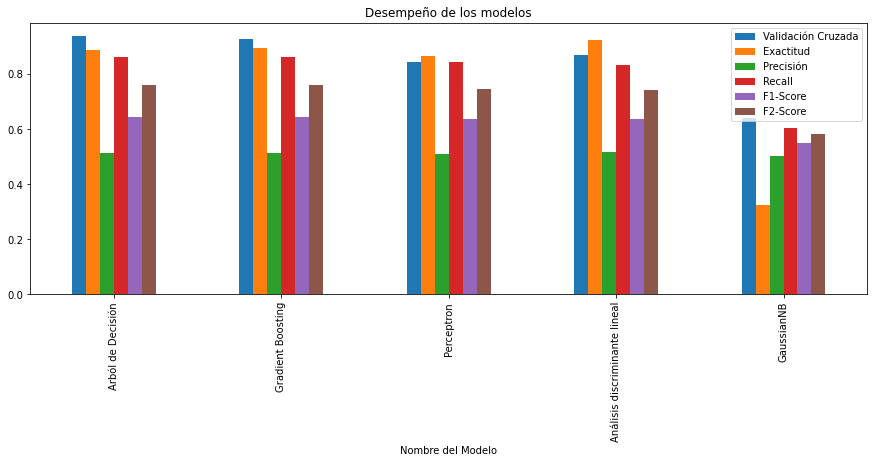

In [107]:
# Crear grafico con el resultado de cada modelo
per_df.plot(kind='bar', figsize=(15, 5), title='Desempeño de los modelos');

In [108]:
# Junto con los dos algoritmos ganadores del notebook donde estaban todos los clientes
# se corrió 3 algoritmos adicionales que no se habían probado antes
# De acuerdo a los resultados el algoritmo que mejor clasifica clientes del dia despues de registro
# teniendo en cuenta F2-Score, Recall, Precision, Exactitud y Validación Cruzada
# ahora es el Arbol de Decisión